# M4 Quarterly Miscellaneous Dataset
This dataset comprises 75 quarterly time series, each spanning March 1998 to June 2017, randomly sampled from the M4 forecasting competition. These series provide a consistent historical window and are ideal for exploring long-term trends and forecasting challenges on quarterly-frequency series drawn from across various sectors.

In [197]:
import pandas as pd
from typing import List, Tuple, Dict, Any
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os
import sys
import random
import matplotlib.pyplot as plt

In [198]:
dataset_name = "m4_quarterly_miscellaneous"

In [199]:
input_fname = "m4_quarterly_dataset.tsf"
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Read Data

In [200]:
def data_line_generator(filepath: str):
    """
    Generator function that yields each line of data after the '@data' marker in the file.

    Args:
    filepath (str): The path to the file from which to read the data.

    Yields:
    str: The next line of data from the file.
    """
    with open(filepath, 'r') as file:
        # Iterate over the file until the '@data' marker is found
        for line in file:
            if line.strip() == "@data":
                break

        # Yield each line of data after the '@data' marker
        for line in file:
            if not line.strip():  # Skip any empty lines that may be present
                continue
            yield line.strip()

# Find lengths of series by series start date

In [201]:

data_gen = data_line_generator(input_fname)

def find_series_lengths_count(max_series=10000):
    '''
    Returns a dictionary of form: 
    {
        (<series_start_date, <series_len>): [list of series_ids of such series...]
    }
    '''
    series_lengths_dict = {}
    for i in range(max_series):
        try:
            line = next(data_gen)
            fields = line.split(":")
            series_name = fields[0]
            series_start_datetime = fields[1]
            series_length = len(fields[-1].split(","))
            id_ = (series_start_datetime, series_length)
            if id_ not in series_lengths_dict:
                series_lengths_dict[id_] = [series_name]
            else: 
                series_lengths_dict[id_].append(series_name)
        except StopIteration: 
            break
        except Exception as e:
            # If any other exception occurs, print the error and the problematic line
            print("An error occurred:", e)
            print("Problematic line:", line)
    return series_lengths_dict

series_lengths_dict = find_series_lengths_count(max_series=200000)

In [202]:
# Confirm Total # of Series
sum([len(s) for s in series_lengths_dict.values()])

24000

In [203]:
# Find count of series per key 
len_counts = {k: len(v) for k, v in series_lengths_dict.items()}
# len_counts

# Find out which series start and length is the most common

In [204]:
max_observed_count_idx = np.argmax(list(len_counts.values()))

max_observed_count_key = list(len_counts.keys())[max_observed_count_idx]
count_of_series = len_counts[max_observed_count_key]

print(
    f"In the M4 quarterly dataset, there are {count_of_series} series"
    f" which started on `{max_observed_count_key[0]}` and have "
    f"length {max_observed_count_key[1]}. \nThis is the highest count"
    " of series with a specific combination of start date and length."
)
# max_observed_count_key, 

In the M4 quarterly dataset, there are 1647 series which started on `1998-03-31 12-00-00` and have length 78. 
This is the highest count of series with a specific combination of start date and length.


In [205]:
target_key = max_observed_count_key

# Let's see how many such series we have in the M4 quarterly dataset. 
len(series_lengths_dict[target_key])

1647

In [206]:
# There are 1647 such series. We will randomly pick 75 from the list.

# Process Full Data

In [207]:
from dateutil.relativedelta import relativedelta

import calendar

def generate_quarter_end_dates(start_date_str, steps):
    # Parse the input string into a datetime object
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d %H-%M-%S')

    # Function to find the last day of a given month
    def last_day_of_month(year, month):
        _, last_day = calendar.monthrange(year, month)
        return last_day

    # Initialize the list of quarter end dates with the start date
    quarter_dates = [start_date.date()]

    # Generate the list of quarter end dates
    for _ in range(steps - 1):
        # Add 3 months to the last date in the list
        next_date = quarter_dates[-1] + relativedelta(months=3)
        # Find the last day of this month
        last_day = last_day_of_month(next_date.year, next_date.month)
        # Create a new date with the last day of the month
        next_date = datetime(next_date.year, next_date.month, last_day).date()
        # Append the next quarter end date to the list
        quarter_dates.append(next_date)

    # Format the dates and return the list
    return quarter_dates

# Test the function with the provided example
date_list = generate_quarter_end_dates(target_key[0], target_key[1])
# print(date_list)

In [208]:
print(date_list)

[datetime.date(1998, 3, 31), datetime.date(1998, 6, 30), datetime.date(1998, 9, 30), datetime.date(1998, 12, 31), datetime.date(1999, 3, 31), datetime.date(1999, 6, 30), datetime.date(1999, 9, 30), datetime.date(1999, 12, 31), datetime.date(2000, 3, 31), datetime.date(2000, 6, 30), datetime.date(2000, 9, 30), datetime.date(2000, 12, 31), datetime.date(2001, 3, 31), datetime.date(2001, 6, 30), datetime.date(2001, 9, 30), datetime.date(2001, 12, 31), datetime.date(2002, 3, 31), datetime.date(2002, 6, 30), datetime.date(2002, 9, 30), datetime.date(2002, 12, 31), datetime.date(2003, 3, 31), datetime.date(2003, 6, 30), datetime.date(2003, 9, 30), datetime.date(2003, 12, 31), datetime.date(2004, 3, 31), datetime.date(2004, 6, 30), datetime.date(2004, 9, 30), datetime.date(2004, 12, 31), datetime.date(2005, 3, 31), datetime.date(2005, 6, 30), datetime.date(2005, 9, 30), datetime.date(2005, 12, 31), datetime.date(2006, 3, 31), datetime.date(2006, 6, 30), datetime.date(2006, 9, 30), datetime.da

In [209]:
data_gen = data_line_generator(input_fname)

def process_data(max_series):
    df_list = []
    timestamp_lookup_dict = {}
    for i in range(max_series):
        try:
            line = next(data_gen)
            fields = line.split(":")
            series_name = fields[0]
            series_start_datetime = fields[1]
            series_vals = fields[-1].split(",")
            num_time_steps = len(series_vals)
            
            # filter for target start year and num of years
            if series_start_datetime != target_key[0] or num_time_steps != target_key[1]:
                continue
                            
            df = pd.DataFrame({'quarter': date_list})
            df['series'] = series_name
            df['value'] = series_vals
            df['value'] = df['value'].astype(float)
            df_list.append(df)
        except StopIteration: 
            break
        except Exception as e:
            # If any other exception occurs, print the error and the problematic line
            print("An error occurred:", e)
            print("Problematic line:", line)
    all_data = pd.concat(df_list)
    return all_data
        
all_data = process_data(max_series=240000)
print(all_data.head())
print(all_data.shape)

      quarter series   value
0  1998-03-31  T4968  4800.0
1  1998-06-30  T4968  8080.0
2  1998-09-30  T4968  9610.0
3  1998-12-31  T4968  6300.0
4  1999-03-31  T4968  8530.0
(128466, 3)


# Limit data to 75 series

In [210]:
random.seed(0)
sampled_series = random.sample(all_data['series'].unique().tolist(), 75)
# print(sampled_series)

In [211]:
# Filter to the sample
final_data = all_data[all_data['series'].isin(sampled_series)].reset_index(drop=True)
print(final_data.shape)

(5850, 3)


In [212]:
final_data.tail()

,quarter,series,value
5845,2016-06-30,T23975,2360.0
5846,2016-09-30,T23975,2328.0
5847,2016-12-31,T23975,2334.4
5848,2017-03-31,T23975,2692.6
5849,2017-06-30,T23975,2673.9


In [213]:
series_col = "series"
epoch_col = "quarter"
time_col="quarter"
value_col = 'value'
exog_cols = []

In [214]:
final_data[time_col] = pd.to_datetime(final_data[time_col])

In [215]:
final_data[time_col].nunique()

78

# Visualize

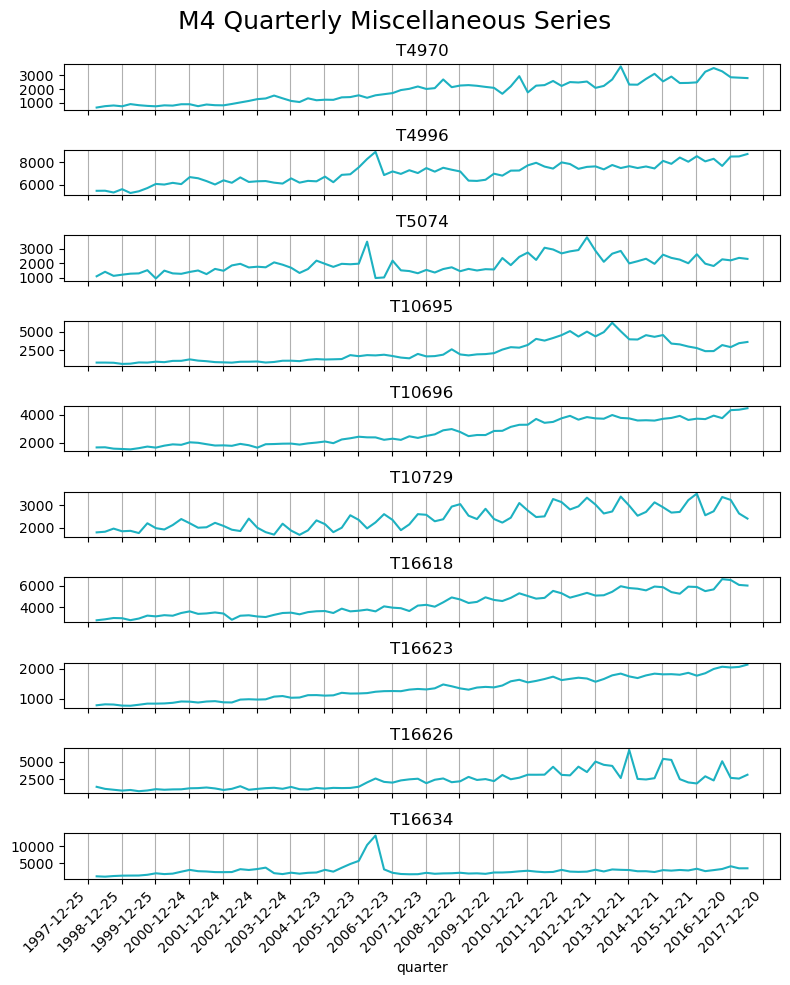

In [216]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        
        # Set x-axis ticks to appear every 5th point
        ax.xaxis.set_major_locator(MultipleLocator(365))
        
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_trends(
    final_data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=epoch_col,
    epoch_label='quarter',
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="M4 Quarterly Miscellaneous Series"
)  


# Save Main Data File

In [217]:
all_cols = [series_col, epoch_col, value_col] + exog_cols    
final_data.sort_values(by=[series_col, epoch_col], inplace=True)
final_data[all_cols].to_csv(outp_fname, index=False)